## Hinge Loss & Gradient

To make the computer find that "wide street," we use a mathematical function called **Hinge Loss** and optimize it using **Gradient Descent**.

**Important Note:** For this math to work, the class labels ($y$) must be **-1** and **1** (not 0 and 1).

### A. The Cost Function ($J$)
The "Cost" is the punishment the model receives. We want this number to be as low as possible.

$$J(w, b) = \underbrace{\lambda ||w||^2}_{\text{Regularization}} + \underbrace{\frac{1}{n} \sum \max(0, 1 - y_i(w \cdot x_i - b))}_{\text{Hinge Loss}}$$

This formula has two parts:
1.  **Regularization ($\lambda ||w||^2$):** Keeps the weights small to maximize the margin (make the street wider).
2.  **Hinge Loss ($\max(0, \dots)$):** The "Quality Inspector".
    * If the point is correctly classified and far from the street (safe), the cost is **0**.
    * If the point is wrongly classified or inside the street (unsafe), the cost **increases**.

[Image of Hinge Loss function graph]

### B. Gradient Descent (The Derivative)

To train the model ("learn"), we need to know which direction to move the line to reduce the error. We do this using the derivative of the cost function.

Since the function has a "kink" (the hinge), there are two possible scenarios for every data point:

#### Scenario 1: Safe Zone (No Error)
* **Situation:** The point is correctly classified and outside the margin ($y \cdot f(x) \ge 1$).
* **The Derivative:** Since the error is 0, the derivative of the error part is 0. Only regularization remains.
* **Update Rule:**
    $$w = w - \alpha \cdot (2\lambda w)$$
    *(We only shrink the weights slightly to try and widen the street).*

#### Scenario 2: Error or Risk Zone
* **Situation:** The model got it wrong, or the point is invading the street ($y \cdot f(x) < 1$).
* **The Derivative:** Here there is an error. The derivative of the Hinge Loss with respect to $w$ is $-y \cdot x$.
* **Update Rule:**
    $$w = w - \alpha \cdot (2\lambda w - y_i \cdot x_i)$$
    $$b = b - \alpha \cdot y_i$$
    *(We shrink the weights AND push the line in the opposite direction of the error to fix it).*

### Visual Summary of the Update

In Python code, this math translates simply to:

```python
# If classification is correct and safe:
if y_i * (np.dot(x_i, w) - b) >= 1:
    w -= learning_rate * (2 * lambda_param * w)

# If there is an error or we are in the margin:
else:
    w -= learning_rate * (2 * lambda_param * w - np.dot(x_i, y_i))
    b -= learning_rate * y_i

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
# Support Vector Machine architecture:
class SVM:
    def __init__(self, hp_lr=0.001, hp_lambda=0.01, n_iters=1000):
        self.hp_lr = hp_lr          # Learning rate
        self.hp_lambda = hp_lambda  # Margin-maximize rate
        self.n_iters = n_iters      # Epochs
        self.w = None               # Weigths
        self.b = None               # Biases

    def fit(self, X, y):
        # Normalize the labels:
        y_ = np.where(y <= 0, -1, 1) # -1 if 'y' <= 0 else 1

        # Design matrix dimensions:
        m, n = X.shape # m: samples, n: features 

        # Init parameters (weights & biases):
        self.w = np.zeros(n)
        self.b = 0

        # Traininng loop:
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                # Verify if data is IN or OUT of margin:
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1

                if condition: # if IN margin:
                    self.w -= self.hp_lr * (2 * self.hp_lambda * self.w) # Regularization (Optional)

                else: # if OUT of margin:
                    self.w -= self.hp_lr * (2 * self.hp_lambda * self.w - np.dot(x_i, y_[idx])) # Apply regularization error
                    self.b -= self.hp_lr * y_[idx] # Move the boarder to the wrong point direction

    def predict(self, X):
        # Calculate the lineal funciton: y = WX - b:
        linear_output = np.dot(X, self.w) - self.b

        return np.sign(linear_output) # (-1 | 1) for class

In [11]:
def visualize_svm(X, y, model):
    def get_hyperplane_value(x, w, b, offset):
        return (-w[0] * x + b + offset) / w[1]

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    
    # Graph data:
    plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=90, cmap='winter')

    # Graph Hiperplane:
    x0_1 = np.amin(X[:, 0])
    x0_2 = np.amax(X[:, 0])

    x1_1 = get_hyperplane_value(x0_1, model.w, model.b, 0)
    x1_2 = get_hyperplane_value(x0_2, model.w, model.b, 0)

    # Graph margins
    x1_1_m = get_hyperplane_value(x0_1, model.w, model.b, -1)
    x1_2_m = get_hyperplane_value(x0_2, model.w, model.b, -1)

    x1_1_p = get_hyperplane_value(x0_1, model.w, model.b, 1)
    x1_2_p = get_hyperplane_value(x0_2, model.w, model.b, 1)

    ax.plot([x0_1, x0_2], [x1_1, x1_2], 'y--', label='Decision Hiperplane') # Línea central
    ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], 'k:', label='Support Vectors') # Margen negativo
    ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], 'k:') # Margen positivo

    x1_min = np.amin(X[:, 1])
    x1_max = np.amax(X[:, 1])
    ax.set_ylim([x1_min - 3, x1_max + 3])
    
    plt.title('Support Vector Machine (2 Features)')
    plt.legend()
    plt.show()

Weigths: [ 0.37313956 -0.09752201]
Biases: -0.21200000000000016


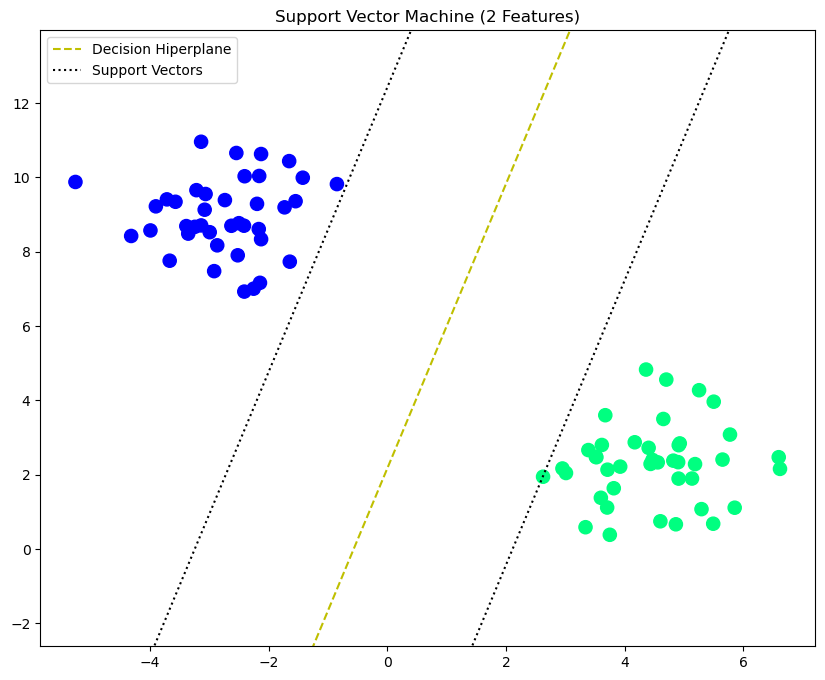

In [12]:
# Generating the synthetic data:
X, y = make_blobs(n_samples=100, n_features=2, centers=2, cluster_std=1.05, random_state=42)

# Convert into -1, 1 labels:
y = np.where(y == 0, -1, 1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparams:
HP_LR = 0.001       # Learning rate
HP_LAMBDA = 0.01    # Lambda parameter
HP_EPOCHS = 1000    # Epochs / Iterations

model = SVM(
    hp_lr=HP_LR,
    hp_lambda=HP_LAMBDA,
    n_iters=HP_EPOCHS
)
model.fit(X_train, y_train) # Train model

# Show the parameters:
print(f"Weigths: {model.w}")
print(f"Biases: {model.b}")

visualize_svm(X_train, y_train, model)

In [ ]:
# Model evaluation:
y_pred = model.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         9

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



Text(0.5, 1.0, 'Confusion Matrix of SVM model')

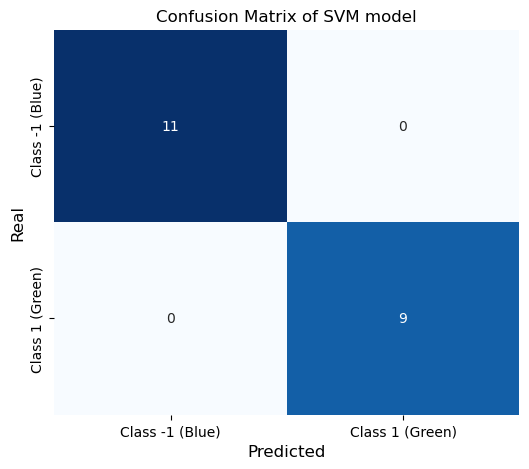

In [15]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class -1 (Blue)', 'Class 1 (Green)'],
            yticklabels=['Class -1 (Blue)', 'Class 1 (Green)'])

plt.ylabel("Real", fontsize=12)
plt.xlabel("Predicted", fontsize=12)
plt.title("Confusion Matrix of SVM model")

### Conclusión: Regresión Logística vs. SVM

* **Regresión Logística (Probabilística):** Le importan **todos** los datos. Busca modelar la probabilidad global de pertenecer a una clase. Nunca está 100% satisfecha y siempre ajusta un poco.


* **SVM (Geométrica):** Le importan solo los **datos difíciles** (vectores de soporte). Busca la separación física más ancha posible (el margen). Ignora por completo los datos seguros.

> **En resumen:** La Regresión Logística busca la **probabilidad** más precisa; la SVM busca la **carretera** más ancha.
